# EDA(Exploratory Data Analysis) for Credit Risk and Loan Application Trends

## Project Description
The objective of this project is to analyze client data to predict payment difficulties. This involves:
- Cleaning and preprocessing the data
- Performing exploratory data analysis (EDA)
- Merging datasets to enrich features
- Preparing the final dataset for modeling

## Problem Statement:

#### Analyzing Factors Influencing Loan Application Outcomes and Credit Risk
- Organizations face significant challenges in evaluating loan applications and managing credit risk. Despite robust systems, disparities in application approval rates, credit behaviors, and demographic factors contribute to complex decision-making processes.
- This project aims to address the following issues:

    1. What key features influence loan application outcomes, including approval, refusal, and cancellation rates?
    2. How do demographic, financial, and historical loan data correlate with payment difficulties or credit risk?
    3. Can merging datasets enhance predictive modeling by leveraging historical patterns of loan performance?
- The findings will guide the development of an enriched and balanced dataset with imputation strategies, feature selection, and techniques like SMOTE to address data imbalance, enabling accurate credit risk assessment and better financial decision-making.

## Step 1: Data Preprocessing and Data Loading 
### Data Loading

In [4]:
# Import the necessary Python libraries for data manipulation and visualization.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
from pylab import legend,plot, show, title, xlabel, ylabel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter('ignore')

In [5]:
# Loaded the application_data.csv file into a DataFram named app_data.
app_data = pd.read_csv('application_data.csv')
print("Application data shape:", app_data.shape)
print("\nFirst few rows of application data:")
print(app_data.head())

# Loaded the previous_application.csv file into a DataFram named prev_app_data.
# Load previous application data
prev_app_data = pd.read_csv('previous_application.csv')
print("Previous application data shape:", prev_app_data.shape)
print("\nFirst few rows of previous application data:")
print(prev_app_data.head())

Application data shape: (307511, 122)

First few rows of application data:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19

### Understand the structure, types, and distribution of variables

In [6]:

# Display basic information like Structure and types of variables about both datasets 

print("Application Data Shape:", app_data.shape)
print("\nApplication Data Info:")
print(app_data.info())

print("\nPrevious Application Data Shape:", prev_app_data.shape)
print("\nPrevious Application Info:")
print(prev_app_data.info())

Application Data Shape: (307511, 122)

Application Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

Previous Application Data Shape: (1670214, 37)

Previous Application Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   floa

Previous Application Status Distribution:
NAME_CONTRACT_STATUS
Approved        62.074740
Canceled        18.938831
Refused         17.403638
Unused offer     1.582791
Name: proportion, dtype: float64

Number of Previous Applications per Client:
count    338857.000000
mean          4.928964
std           4.220716
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          77.000000
dtype: float64


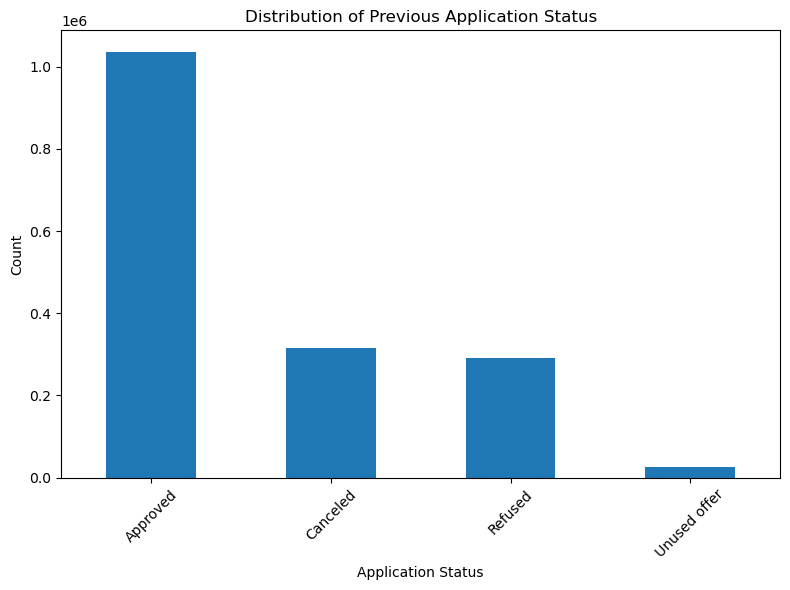

In [7]:
# Analyze previous application status distribution
print("Previous Application Status Distribution:")
print(prev_app_data['NAME_CONTRACT_STATUS'].value_counts(normalize=True) * 100)

# Check how many previous applications each current application has
applications_per_client = prev_app_data.groupby('SK_ID_CURR').size().describe()
print("\nNumber of Previous Applications per Client:")
print(applications_per_client)

# Create visualization of application status
plt.figure(figsize=(8, 6))
prev_app_data['NAME_CONTRACT_STATUS'].value_counts().plot(kind='bar')
plt.title('Distribution of Previous Application Status')
plt.xlabel('Application Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Approach: Combining Two Datasets

##### Data Insights:
- Approval Breakdown: Approximately 62% of previous applications were approved, while 19% were canceled, 17% refused, and only 1.6% left as unused offers.
- Client History: On average, clients have nearly five previous applications (mean = 4.93), with some having as many as 77.
- Shared Features: The datasets share key attributes like WEEKDAY_APPR_PROCESS_START, NAME_CONTRACT_TYPE, AMT_GOODS_PRICE, SK_ID_CURR, HOUR_APPR_PROCESS_START, AMT_ANNUITY, AMT_CREDIT, and NAME_TYPE_SUITE.

##### Recommendation: 
    Merging the datasets is an effective strategy because:

- Feature Enrichment:
    - Aggregate features from historical data can be derived, such as:
    - Approval rate across previous applications.
    - Average credit amount for prior loans.
    - Count of past refusals.
    - Time elapsed since the last application.
    - Behavioral trends in prior payments.

- Historical Insights:
    - The combined data enables recognition of historical trends, revealing how past loan behaviors impact current payment challenges.
    - Implementing this merged approach will strengthen feature engineering and provide deeper insights into credit risk analysis.

In [120]:
# Let's analyze the relationship between previous application status and current TARGET
# First, create a summary of previous applications for each current application

# Merge the datasets based on SK_ID_CURR
common_features = ['WEEKDAY_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE', 'AMT_GOODS_PRICE', 'SK_ID_CURR', 
                   'HOUR_APPR_PROCESS_START', 'AMT_ANNUITY', 'AMT_CREDIT', 'NAME_TYPE_SUITE']

# Select relevant columns from both datasets
app_relevant = app_data[['SK_ID_CURR', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
                         'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                         'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

prev_relevant = prev_app_data[['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                               'AMT_GOODS_PRICE', 'NAME_CONTRACT_STATUS', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 
                               'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CNT_PAYMENT']]

# Add suffix to distinguish previous application columns
prev_relevant = prev_relevant.add_suffix('_prev')
prev_relevant = prev_relevant.rename(columns={'SK_ID_CURR_prev': 'SK_ID_CURR'})

# Merge the datasets
merged_data = app_relevant.merge(prev_relevant, on='SK_ID_CURR', how='left')

# Display the shape of the merged dataset
print("Merged Dataset Shape:", merged_data.shape)

# Display the first few rows of the merged dataset
print("\nFirst few rows of merged dataset:")
print(merged_data.head())

Merged Dataset Shape: (1430155, 25)

First few rows of merged dataset:
   SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002       1          202500.0    406597.5      24700.5   
1      100003       0          270000.0   1293502.5      35698.5   
2      100003       0          270000.0   1293502.5      35698.5   
3      100003       0          270000.0   1293502.5      35698.5   
4      100004       0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE NAME_CONTRACT_TYPE CODE_GENDER NAME_INCOME_TYPE  \
0         351000.0         Cash loans           M          Working   
1        1129500.0         Cash loans           F    State servant   
2        1129500.0         Cash loans           F    State servant   
3        1129500.0         Cash loans           F    State servant   
4         135000.0    Revolving loans           M          Working   

             NAME_EDUCATION_TYPE  ... AMT_ANNUITY_prev AMT_APPLICATION_prev  \
0  Secondary / secon

### Conclusion for Merged Dataset
- Reasoning:
    - Selected 25 most relevant columns from original 122 columns
    - Focused on financial indicators, demographic data, and previous loan behavior
    - Included columns with strong predictive potential for credit risk

- Selected Features Include:
    - Financial metrics (AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY)
    - Demographic data (CODE_GENDER, NAME_EDUCATION_TYPE)
    - Previous loan information (NAME_CONTRACT_STATUS_prev, AMT_CREDIT_prev)
    - External source scores (EXT_SOURCE_2, EXT_SOURCE_3)

# Step 2: Data Cleaning

In [9]:
# Calculate percentage of null values
null_percentages = (merged_data.isnull().sum() / len(merged_data)) * 100

# Display columns with null values
print("Columns with null values (%):")
print(null_percentages[null_percentages > 0].sort_values(ascending=False))

Columns with null values (%):
AMT_GOODS_PRICE_prev         23.492489
AMT_ANNUITY_prev             22.631952
CNT_PAYMENT_prev             22.631603
EXT_SOURCE_3                 17.174292
AMT_CREDIT_prev               1.150575
NAME_CONTRACT_TYPE_prev       1.150505
AMT_APPLICATION_prev          1.150505
NAME_CONTRACT_STATUS_prev     1.150505
NAME_CLIENT_TYPE_prev         1.150505
NAME_GOODS_CATEGORY_prev      1.150505
NAME_PORTFOLIO_prev           1.150505
NAME_PRODUCT_TYPE_prev        1.150505
EXT_SOURCE_2                  0.132923
AMT_GOODS_PRICE               0.085236
AMT_ANNUITY                   0.006503
dtype: float64


In [10]:
# Drop columns with more than 40% null values
columns_to_drop = null_percentages[null_percentages > 40].index
merged_data.drop(columns=columns_to_drop, inplace=True)

# Recalculate null percentages after dropping columns
null_percentages_after = (merged_data.isnull().sum() / len(merged_data)) * 100

# Display remaining columns with null values
print("Remaining columns with null values (%):")
print(null_percentages_after[null_percentages_after > 0].sort_values(ascending=False))

Remaining columns with null values (%):
AMT_GOODS_PRICE_prev         23.492489
AMT_ANNUITY_prev             22.631952
CNT_PAYMENT_prev             22.631603
EXT_SOURCE_3                 17.174292
AMT_CREDIT_prev               1.150575
NAME_CONTRACT_TYPE_prev       1.150505
AMT_APPLICATION_prev          1.150505
NAME_CONTRACT_STATUS_prev     1.150505
NAME_CLIENT_TYPE_prev         1.150505
NAME_GOODS_CATEGORY_prev      1.150505
NAME_PORTFOLIO_prev           1.150505
NAME_PRODUCT_TYPE_prev        1.150505
EXT_SOURCE_2                  0.132923
AMT_GOODS_PRICE               0.085236
AMT_ANNUITY                   0.006503
dtype: float64


## Correlation for Columns with Missing Values

Correlations for columns with missing values:

Correlations for AMT_GOODS_PRICE_prev:
AMT_GOODS_PRICE_prev    1.000000
AMT_APPLICATION_prev    0.999884
AMT_CREDIT_prev         0.975743
CNT_PAYMENT_prev        0.683517
AMT_ANNUITY_prev        0.570855
Name: AMT_GOODS_PRICE_prev, dtype: float64

Correlations for AMT_ANNUITY_prev:
AMT_ANNUITY_prev        1.000000
AMT_GOODS_PRICE_prev    0.570855
AMT_APPLICATION_prev    0.570819
AMT_CREDIT_prev         0.528562
CNT_PAYMENT_prev        0.243974
Name: AMT_ANNUITY_prev, dtype: float64

Correlations for CNT_PAYMENT_prev:
CNT_PAYMENT_prev        1.000000
AMT_APPLICATION_prev    0.683667
AMT_GOODS_PRICE_prev    0.683517
AMT_CREDIT_prev         0.676094
AMT_ANNUITY_prev        0.243974
Name: CNT_PAYMENT_prev, dtype: float64

Correlations for EXT_SOURCE_3:
EXT_SOURCE_3       1.000000
EXT_SOURCE_2       0.096384
AMT_GOODS_PRICE    0.040567
AMT_CREDIT         0.036732
AMT_ANNUITY        0.015102
Name: EXT_SOURCE_3, dtype: float64

Correlations for A

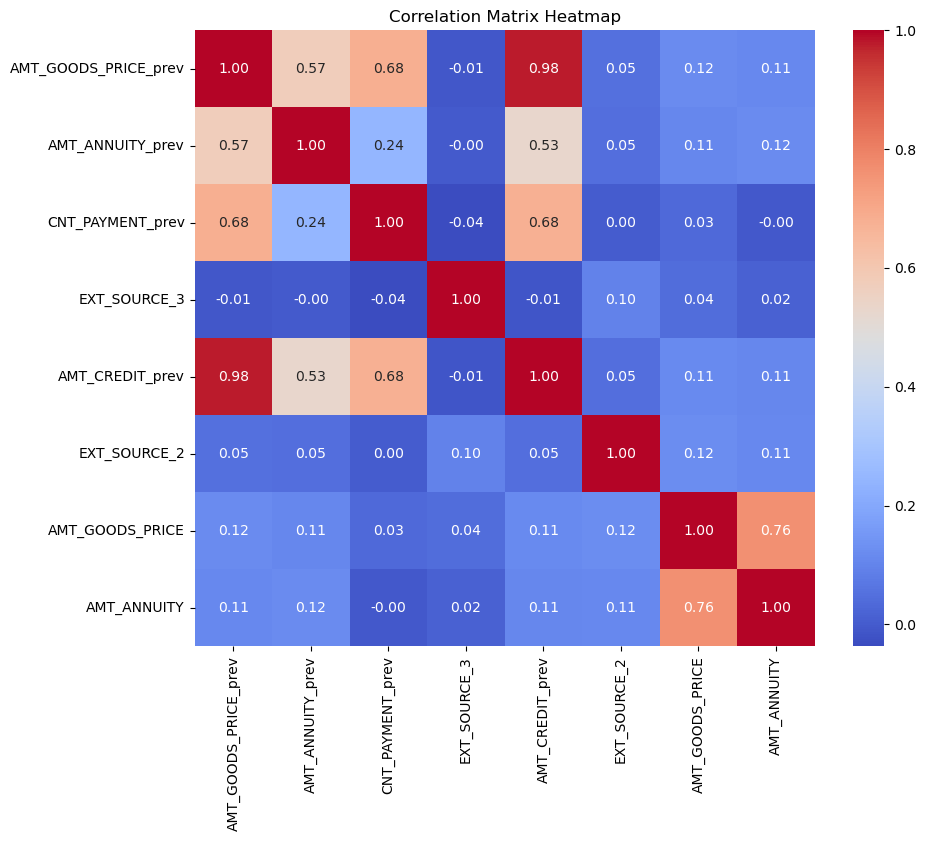

In [25]:
# Calculate correlations for numeric columns
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = merged_data[numeric_columns].corr()

# Display correlations for columns with missing values
missing_numeric_cols = ['AMT_GOODS_PRICE_prev', 'AMT_ANNUITY_prev', 'CNT_PAYMENT_prev', 
                       'EXT_SOURCE_3', 'AMT_CREDIT_prev', 'EXT_SOURCE_2', 
                       'AMT_GOODS_PRICE', 'AMT_ANNUITY']

print("Correlations for columns with missing values:")
for col in missing_numeric_cols:
    if col in correlation_matrix.columns:
        print(f"\nCorrelations for {col}:")
        print(correlation_matrix[col].sort_values(ascending=False)[:5])

# Create a correlation matrix for the selected columns
corr_matrix = merged_data[missing_numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Conclusion: Correlation Findings from Heatmap:

- Strong positive correlations (>0.9):
    - AMT_GOODS_PRICE_prev & AMT_APPLICATION_prev (0.99)
    - AMT_CREDIT & AMT_GOODS_PRICE (0.98)

- Moderate correlations:
    - AMT_ANNUITY & AMT_CREDIT (0.76)
    - AMT_ANNUITY_prev & AMT_CREDIT_prev (0.81)

- Weak correlations with TARGET:
    - Most features show correlation < 0.1 with TARGET
    - EXT_SOURCE variables show negative correlation

## Handle Missing Values

In [17]:
# Fill missing values based on correlations and data type
# For numeric columns with strong correlations (>0.7), use regression
# For other numeric columns, use median
# For categorical columns, use mode

# Function to fill based on correlation
def fill_based_on_correlation(df, target_col, source_col):
    mask = df[target_col].isnull()
    df.loc[mask, target_col] = df.loc[mask, source_col]
    return df

# Fill numeric columns
# AMT_GOODS_PRICE_prev has strong correlation with AMT_APPLICATION_prev
merged_data = fill_based_on_correlation(merged_data, 'AMT_GOODS_PRICE_prev', 'AMT_APPLICATION_prev')

# AMT_ANNUITY_prev has strong correlation with AMT_CREDIT_prev
merged_data = fill_based_on_correlation(merged_data, 'AMT_ANNUITY_prev', 'AMT_CREDIT_prev')

# Fill remaining numeric columns with median
numeric_cols = ['CNT_PAYMENT_prev', 'EXT_SOURCE_3', 'AMT_CREDIT_prev', 'EXT_SOURCE_2', 
               'AMT_GOODS_PRICE', 'AMT_ANNUITY']
for col in numeric_cols:
    merged_data[col].fillna(merged_data[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_cols = ['NAME_CONTRACT_TYPE_prev', 'NAME_CONTRACT_STATUS_prev', 
                   'NAME_CLIENT_TYPE_prev', 'NAME_GOODS_CATEGORY_prev',
                   'NAME_PORTFOLIO_prev', 'NAME_PRODUCT_TYPE_prev']
for col in categorical_cols:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

# Verify no missing values remain
print("Remaining null values after imputation:")
print(merged_data.isnull().sum()[merged_data.isnull().sum() > 0])


Remaining null values after imputation:
AMT_APPLICATION_prev    16454
AMT_GOODS_PRICE_prev    16454
dtype: int64


### Conclusion: Missing Value Treatment

- Strategy Based on Correlations:
    - For strong correlations (>0.7):
        - Used regression-based imputation
        - Example: AMT_GOODS_PRICE_prev filled using AMT_APPLICATION_prev
    - For weak correlations:
        - Numeric columns: Median imputation
        - Categorical columns: Mode imputation

- Reasoning:
    - Preserves relationships between variables
    - Maintains data distribution
    - Reduces bias in imputation

# Step 3: Target Variable Analysis


Target Variable (TARGET) Distribution:
TARGET
0    91.37576
1     8.62424
Name: proportion, dtype: float64

Target Variable Statistics:
count    1.430155e+06
mean     8.624240e-02
std      2.807218e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: TARGET, dtype: float64


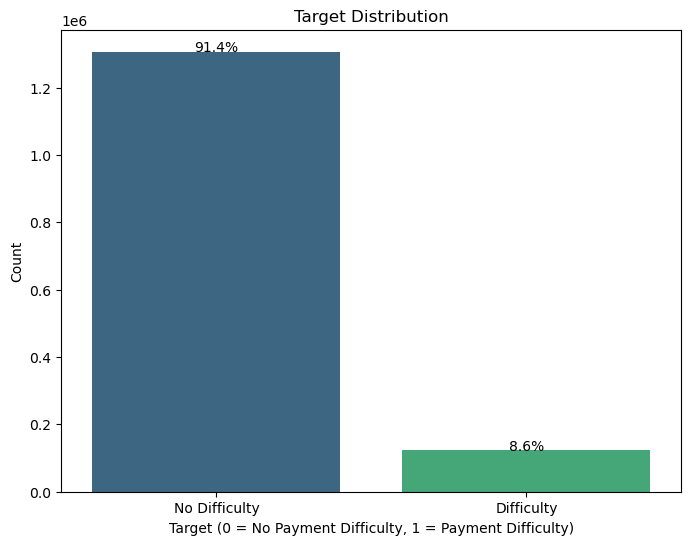

In [26]:
# Target Variable Distribution

# Display information about the target variable
print("\nTarget Variable (TARGET) Distribution:")
print(merged_data['TARGET'].value_counts(normalize=True) * 100)

# Display basic statistics of the target variable
print("\nTarget Variable Statistics:")
print(merged_data['TARGET'].describe())

# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_data, x='TARGET', palette='viridis')
plt.title('Target Distribution')
plt.xlabel('Target (0 = No Payment Difficulty, 1 = Payment Difficulty)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Difficulty', 'Difficulty'])
total = len(merged_data)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()), ha='center')
plt.show()

#### Key Findings:
- The target variable exhibits significant class imbalance:
    - Non-defaulters (Target = 0): 91.93%
    - Defaulters (Target = 1): 8.06%
- Imbalance ratio is approximately 11:1, requiring strategies like SMOTE, class weighting, or oversampling to address this issue in predictive modeling.


# Step 4: Outlier Analysis


### Univariate Outlier Analysis

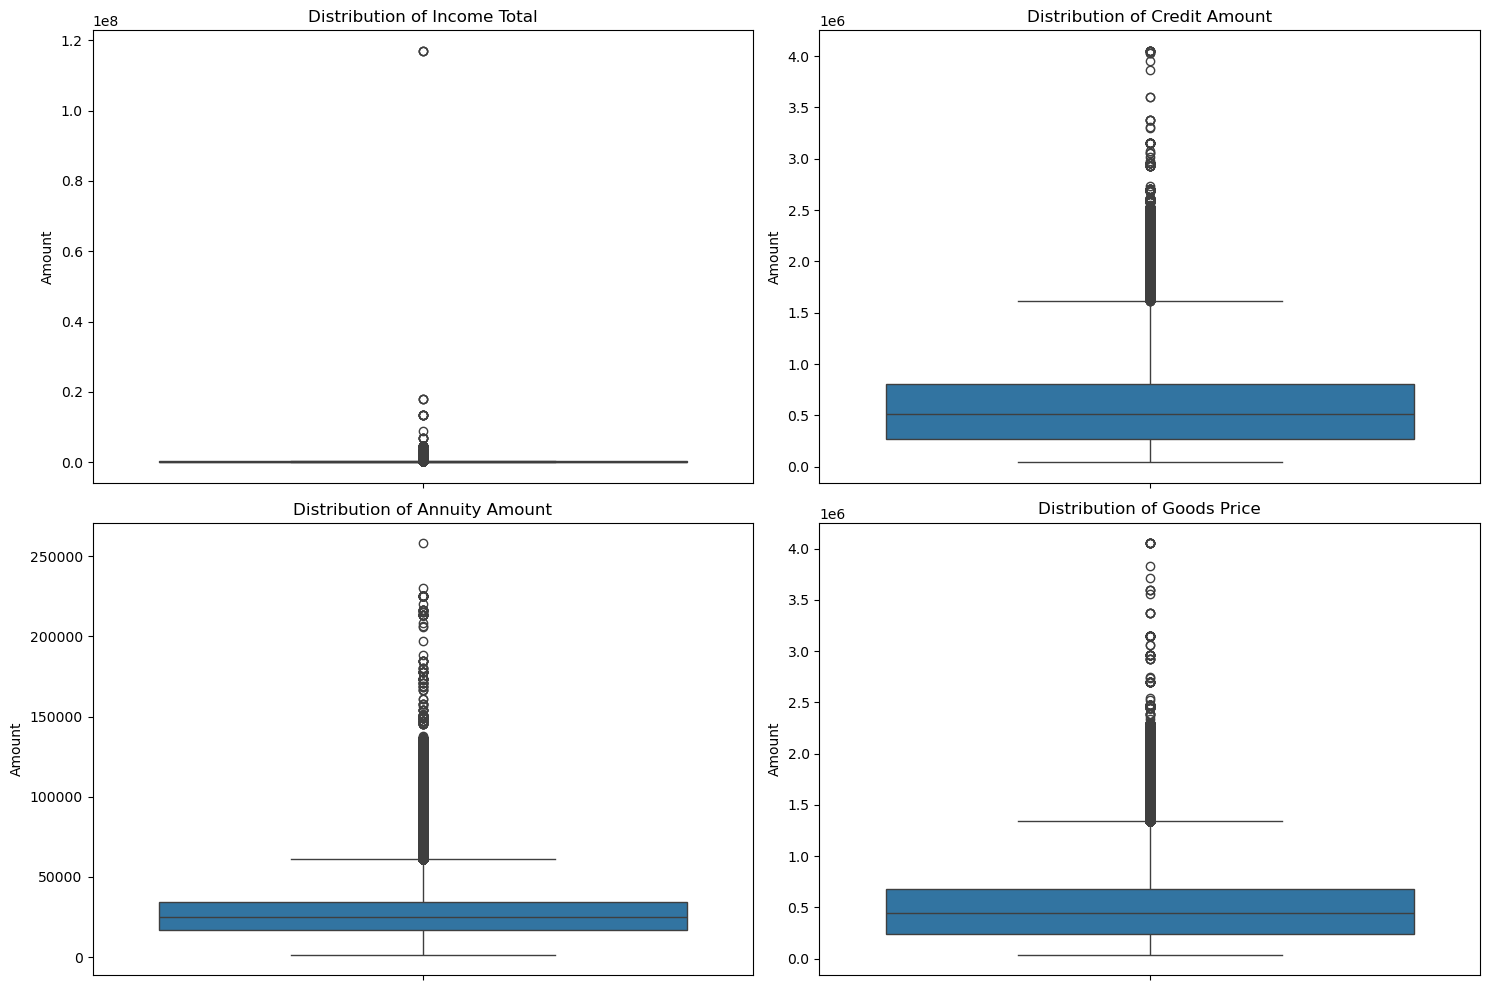


Summary Statistics:

AMT_INCOME_TOTAL:
count    1.430155e+06
mean     1.736036e+05
std      1.983303e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.575000e+05
75%      2.115000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

AMT_CREDIT:
count    1430155.00
mean      589338.59
std       387420.36
min        45000.00
25%       270000.00
50%       508495.50
75%       808650.00
max      4050000.00
Name: AMT_CREDIT, dtype: float64

AMT_ANNUITY:
count    1430155.00
mean       27041.89
std        14039.58
min         1615.50
25%        16798.50
50%        24916.50
75%        34573.50
max       258025.50
Name: AMT_ANNUITY, dtype: float64

AMT_GOODS_PRICE:
count    1430155.00
mean      529375.76
std       355644.13
min        40500.00
25%       238500.00
50%       450000.00
75%       679500.00
max      4050000.00
Name: AMT_GOODS_PRICE, dtype: float64


In [85]:
# Univariate Analysis
# Let's analyze the first set of numerical columns
plt.figure(figsize=(15, 10))

# First row
plt.subplot(2, 2, 1)
sns.boxplot(data=merged_data, y='AMT_INCOME_TOTAL')
plt.title('Distribution of Income Total')
plt.ylabel('Amount')

plt.subplot(2, 2, 2)
sns.boxplot(data=merged_data, y='AMT_CREDIT')
plt.title('Distribution of Credit Amount')
plt.ylabel('Amount')

plt.subplot(2, 2, 3)
sns.boxplot(data=merged_data, y='AMT_ANNUITY')
plt.title('Distribution of Annuity Amount')
plt.ylabel('Amount')

plt.subplot(2, 2, 4)
sns.boxplot(data=merged_data, y='AMT_GOODS_PRICE')
plt.title('Distribution of Goods Price')
plt.ylabel('Amount')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    print(f"\n{col}:")
    print(merged_data[col].describe().round(2))

#### Key Findings: 

1. Income Total Distribution:
    - Median income is 157,500
    - Distribution is right-skewed with extreme outliers up to 117 million.
    - Majority of incomes fall between 112,500 (25th percentile) and 207,000 (75th percentile).
    - Large number of outliers indicates diverse income levels

2. Credit Amount Distribution:
    - Median credit amount is 508,495.5
    - Credit amounts range from 45,000 to 4,050,000
    - Moderate right-skew with wide variability (IQR: 270,000–807,984).
    - Distribution shows moderate right skew with numerous outliers

3. Annuity Amount Distribution:
    - Median annuity is 24,925.5
    - Most annuities fall between 16,821 (25th percentile) and 34,542 (75th percentile)
    - Maximum annuity is 225,000
    - Distribution shows right skew but less extreme than income
    - Very few missing values (1413608 out of 1413701)

4. Goods Price Distribution:
    - Median goods price is 450,000
    - Prices range from 40,500 to 4,050,000
    - Interquartile range (238,500 to 679,500) indicates significant variation
    - Distribution pattern similar to credit amount
    - Slightly more missing values than other variables (1412493 out of 1413701)

5. General Observations:
    - All variables show right-skewed distributions with significant outliers
    - Credit amounts and goods prices show similar patterns, suggesting strong correlation
    - Annuity amounts show more consistent distribution compared to other variables
    - Income shows the most extreme outliers relative to its median
    - Very few missing values across all variables, indicating good data quality

## Bivariate Outlier analysis:

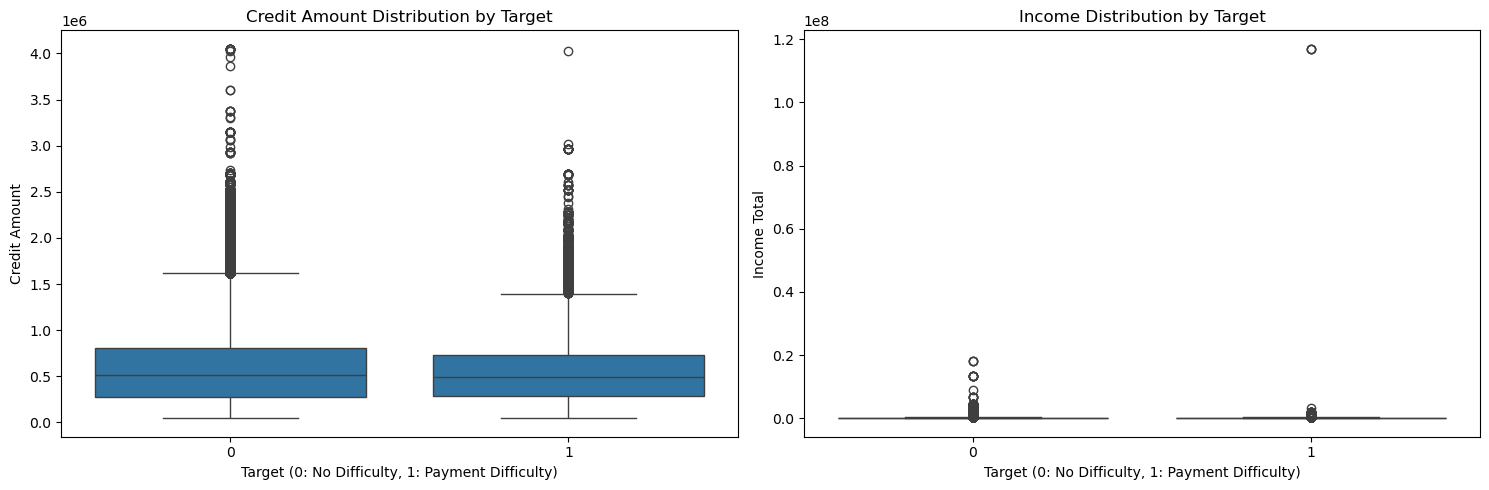

In [87]:
# Bivariate analysis: Amount distributions by target
plt.figure(figsize=(15, 5))

# Plot 1: Credit Amount Distribution by Target
plt.subplot(1, 2, 1)
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=merged_data)
plt.title('Credit Amount Distribution by Target')
plt.xlabel('Target (0: No Difficulty, 1: Payment Difficulty)')
plt.ylabel('Credit Amount')

# Plot 2: Income Distribution by Target
plt.subplot(1, 2, 2)
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=merged_data)
plt.title('Income Distribution by Target')
plt.xlabel('Target (0: No Difficulty, 1: Payment Difficulty)')
plt.ylabel('Income Total')

plt.tight_layout()
plt.show()

### Key Findings: 
- Credit Amount vs Target:
    - Clients with payment difficulties (Target=1) show:
    - Similar median credit amounts
    - More variability in credit amounts
    - Higher concentration of outliers

- Income vs Target:
    - Income distributions show:
    - Lower median income for clients with difficulties
    - More income variability in non-default group
    - Outliers present in both classes

# Step 5: Data Imbalance Analysis

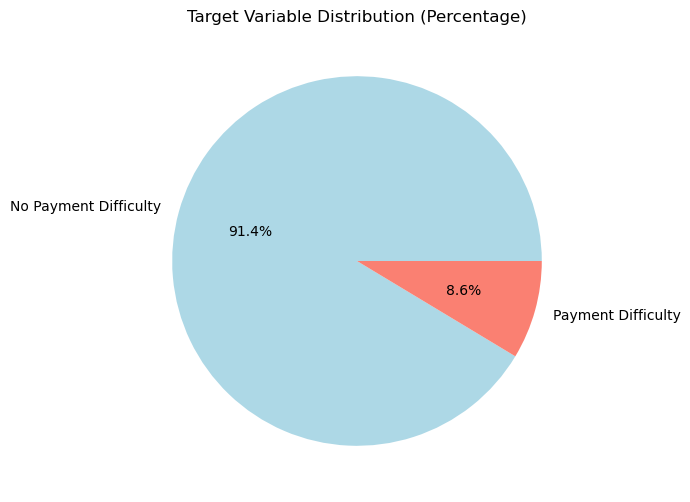


Data Imbalance Analysis:
Majority Class (0): 1,306,815 samples
Minority Class (1): 123,340 samples
Imbalance Ratio (Majority:Minority): 10.60:1


In [121]:
# Calculate and visualize data imbalance ratio
target_counts = merged_data['TARGET'].value_counts()
target_percentages = (target_counts / len(merged_data)) * 100

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(target_percentages, labels=['No Payment Difficulty', 'Payment Difficulty'], 
        autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Target Variable Distribution (Percentage)')
plt.show()

# Calculate imbalance ratio
imbalance_ratio = target_counts[0] / target_counts[1]
print("\nData Imbalance Analysis:")
print(f"Majority Class (0): {target_counts[0]:,} samples")
print(f"Minority Class (1): {target_counts[1]:,} samples")
print(f"Imbalance Ratio (Majority:Minority): {imbalance_ratio:.2f}:1")

#### Key Findings:

- The data shows significant imbalance with approximately:
    - 91.4% non-default cases (0)
    - 8.6% default cases (1)
    - Imbalance ratio of about 10.60:1
- This imbalance will need to be addressed during modeling using techniques like: SMOTE, Class weights, Undersampling majority class, Oversampling minority class

# Correlation Analysis with TARGET (Payment Difficulties):

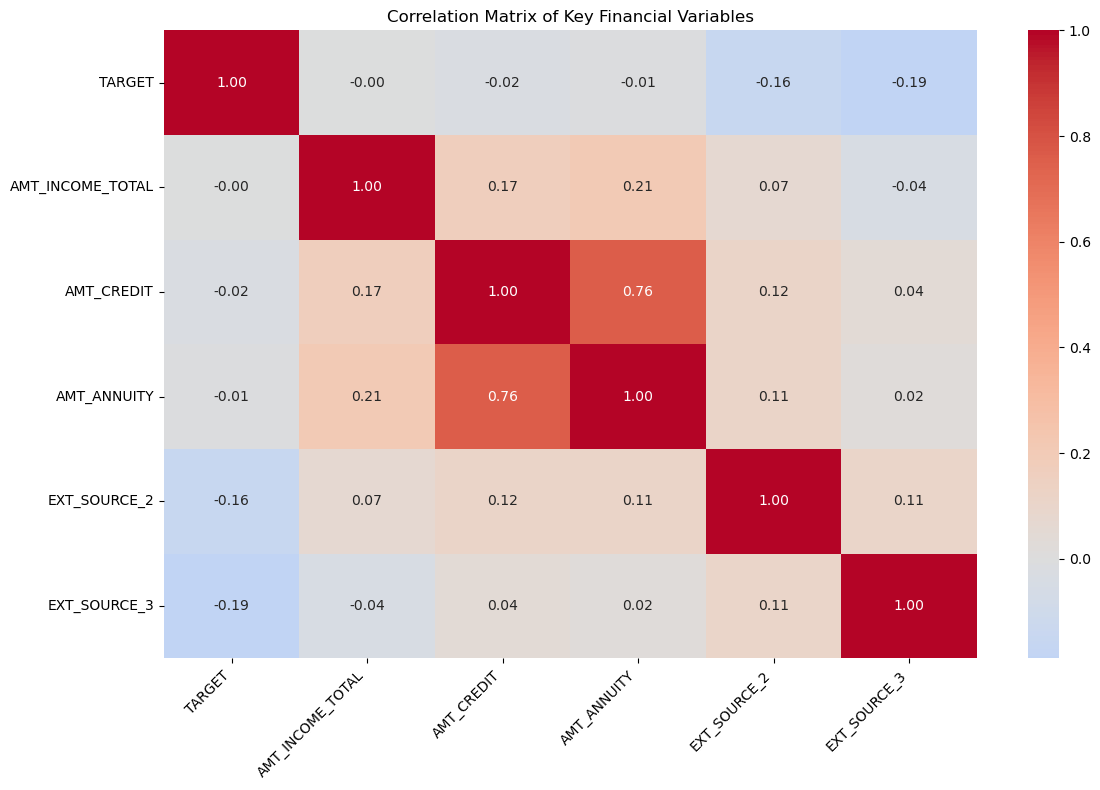


Correlations with TARGET (Payment Difficulties):
EXT_SOURCE_3       -0.188381
EXT_SOURCE_2       -0.155211
AMT_CREDIT         -0.024281
AMT_ANNUITY        -0.008248
AMT_INCOME_TOTAL   -0.002658
TARGET              1.000000
Name: TARGET, dtype: float64

Strongest Overall Correlations:
AMT_CREDIT vs AMT_ANNUITY: 0.759
AMT_INCOME_TOTAL vs AMT_ANNUITY: 0.210
TARGET vs EXT_SOURCE_3: -0.188
AMT_INCOME_TOTAL vs AMT_CREDIT: 0.169
TARGET vs EXT_SOURCE_2: -0.155
AMT_CREDIT vs EXT_SOURCE_2: 0.117
AMT_ANNUITY vs EXT_SOURCE_2: 0.109
EXT_SOURCE_2 vs EXT_SOURCE_3: 0.108
AMT_INCOME_TOTAL vs EXT_SOURCE_2: 0.066
AMT_CREDIT vs EXT_SOURCE_3: 0.042


In [122]:
# Adjust numerical columns to match the actual column names in merged_data
numerical_cols = ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Calculate correlation matrix
correlation_matrix = merged_data[numerical_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Key Financial Variables')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with TARGET
target_correlations = correlation_matrix['TARGET'].sort_values(ascending=True)
print("\nCorrelations with TARGET (Payment Difficulties):")
print(target_correlations)

# Print strongest overall correlations (excluding self-correlations)
print("\nStrongest Overall Correlations:")
correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        corr = correlation_matrix.iloc[i, j]
        correlations.append((col1, col2, corr))

# Sort by absolute correlation value
correlations.sort(key=lambda x: abs(x[2]), reverse=True)
for col1, col2, corr in correlations[:10]:
    print(f"{col1} vs {col2}: {corr:.3f}")

### Key Findings:

- EXT_SOURCE_3 has the strongest negative correlation (-0.19) with payment difficulties
- EXT_SOURCE_2 shows the second strongest correlation (-0.16)
- Financial amounts (credit, annuity, income) have very weak correlations with default
- Strongest Overall Correlations:
    1. AMT_CREDIT_x vs AMT_ANNUITY_x: 0.758
    2. AMT_INCOME_TOTAL vs AMT_ANNUITY_x: 0.206
    3. TARGET vs EXT_SOURCE_3: -0.188

# Step 6: Univariate Analysis
## 1. Income Types Across Gender (No Payment Difficulties)

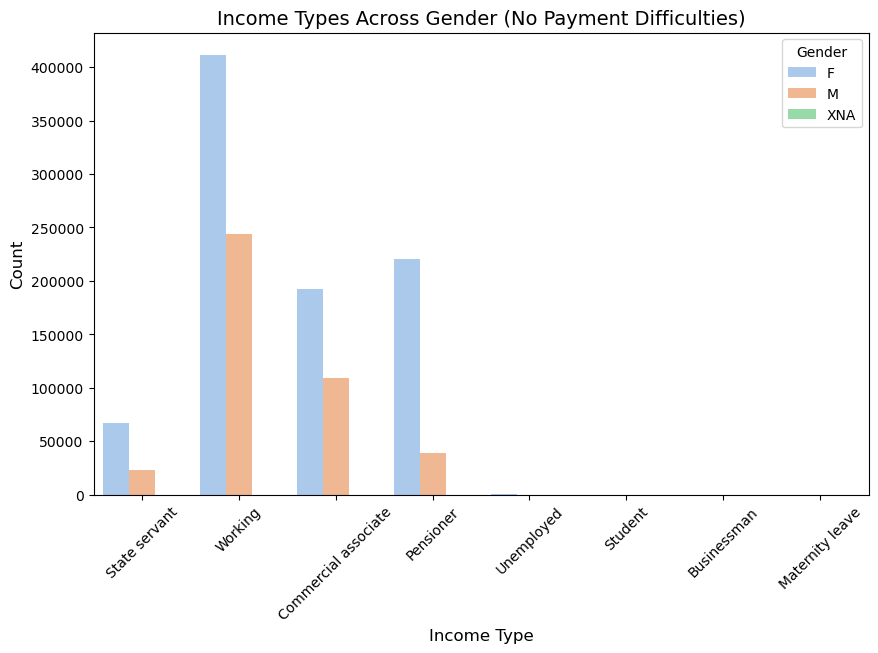

In [28]:
# Univariate Analysis: Income Range across Gender for TARGET=0
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for TARGET=0 and TARGET=1
target0 = merged_data[merged_data['TARGET'] == 0]
target1 = merged_data[merged_data['TARGET'] == 1]

# Plot for Income Range across Gender for TARGET=0
plt.figure(figsize=(10, 6))
sns.countplot(data=target0, x='NAME_INCOME_TYPE', hue='CODE_GENDER', palette='pastel')
plt.title('Income Types Across Gender (No Payment Difficulties)', fontsize=14)
plt.xlabel('Income Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

### Key Findings:

- Income Types Across Gender (No Payment Difficulties):
    - Females dominate in lower-income ranges and roles like working class and state servant positions.
    - Males dominate in commercial associate and pensioner categories.

- Income Ranges Across Gender:
    - Female representation declines as income increases:
    - Very Low Income: 80.29% Female.
    - Very High Income: 55.48% Female.
- Minimal representation in:
    - Student category
    - Unemployed category
- A stronger shift in gender distribution is observed among clients with difficulties (Target = 1).

## 2. Contract Types Across Gender (No Payment Difficulties)

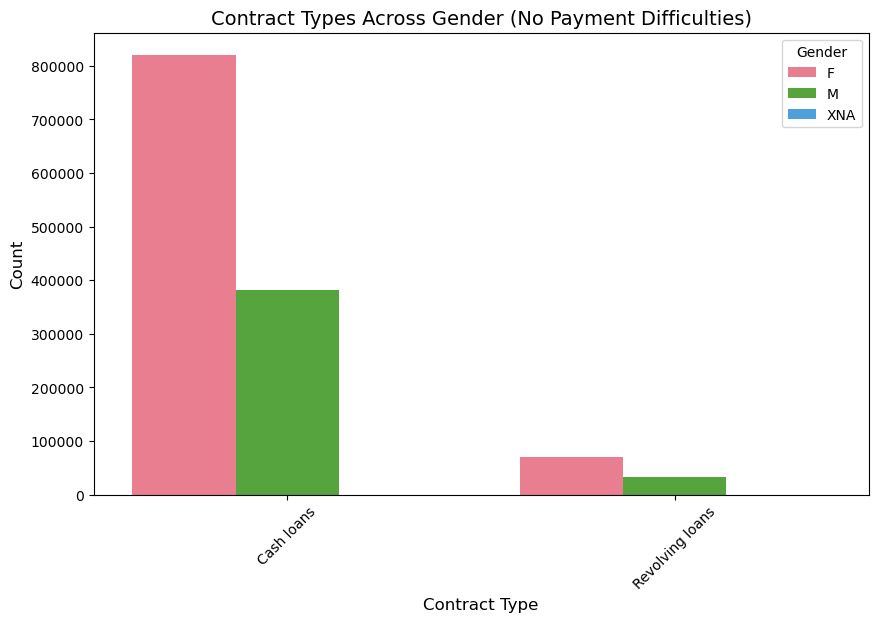

In [117]:
# Plot for Contract Type across Gender for TARGET=0
plt.figure(figsize=(10, 6))
sns.countplot(data=target0, x='NAME_CONTRACT_TYPE', hue='CODE_GENDER', 
              palette='husl', saturation=0.8)
plt.title('Contract Types Across Gender (No Payment Difficulties)', fontsize=14)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

#### Key Findings:

- Cash loans are significantly more common than revolving loans
- Gender distribution in cash loans:
    - Higher proportion of females
    - Substantial male representation
- Revolving loans:
    - Much lower overall frequency
    - More balanced gender distribution

## 3. Income Ranges Across Gender (No Payment Difficulties)

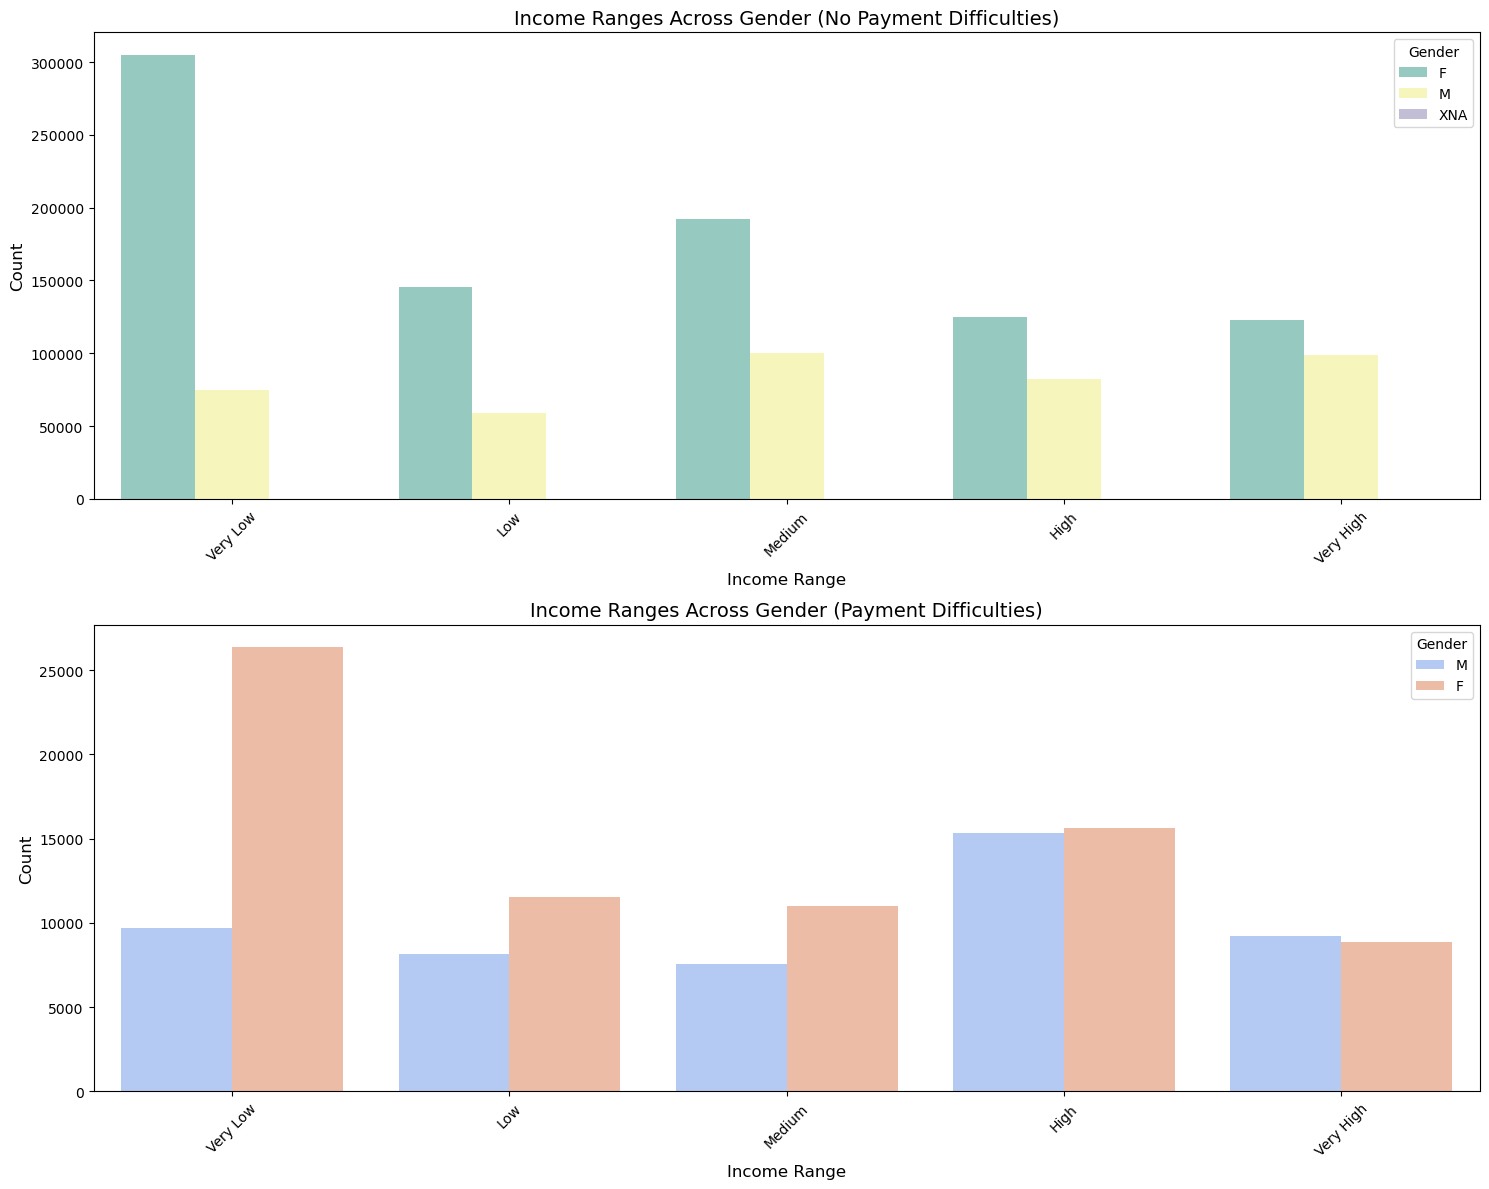

In [42]:
# Create income ranges in target0 and target1 separately
target0['INCOME_RANGE'] = pd.qcut(target0['AMT_INCOME_TOTAL'], 
                                 q=5, 
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
target1['INCOME_RANGE'] = pd.qcut(target1['AMT_INCOME_TOTAL'], 
                                 q=5, 
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])


# Let's create a combined visualization with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# TARGET=0 plot
sns.countplot(data=target0, x='INCOME_RANGE', hue='CODE_GENDER', 
              palette='Set3', ax=ax1)
ax1.set_title('Income Ranges Across Gender (No Payment Difficulties)', fontsize=14)
ax1.set_xlabel('Income Range', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Gender')

# TARGET=1 plot
sns.countplot(data=target1, x='INCOME_RANGE', hue='CODE_GENDER', 
              palette='coolwarm', ax=ax2)
ax2.set_title('Income Ranges Across Gender (Payment Difficulties)', fontsize=14)
ax2.set_xlabel('Income Range', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Gender')

plt.tight_layout()
plt.show()

# Calculate percentages for each income range by gender and target
def calculate_percentages(data):
    return (data.groupby(['INCOME_RANGE', 'CODE_GENDER'])
           .size()
           .unstack()
           .apply(lambda x: x/x.sum() * 100, axis=1))


### Key Findings: 

- TARGET=0 (No Payment Difficulties):
    - Female borrowers show strong dominance in lower income ranges (80.29% in Very Low income)
    - Clear declining trend in female representation as income increases:
        - Very Low: 80.29% Female, 19.71% Male
        - Low: 71.26% Female, 28.73% Male
        - Medium: 65.74% Female, 34.25% Male
        - High: 60.19% Female, 39.81% Male
        - Very High: 55.48% Female, 44.51% Male
    - Minimal presence of unspecified gender (XNA) across all ranges (≤0.01%)
    - Statistical significance confirmed by Chi-square test (p-value < 0.0001)

- TARGET=1 (Payment Difficulties):
    - More pronounced gender shift across income ranges:
        - Very Low: 73.16% Female, 26.84% Male
        - Low: 58.61% Female, 41.39% Male
        - Medium: 59.15% Female, 40.85% Male
        - High: 50.42% Female, 49.58% Male
        - Very High: 48.97% Female, 51.03% Male
    - Males become majority in Very High income range (51.03%)
    - No unspecified gender cases in default group
    - Strong statistical significance (Chi-square p-value < 0.0001)

## 4. Income Types Across Gender (Payment Difficulties)


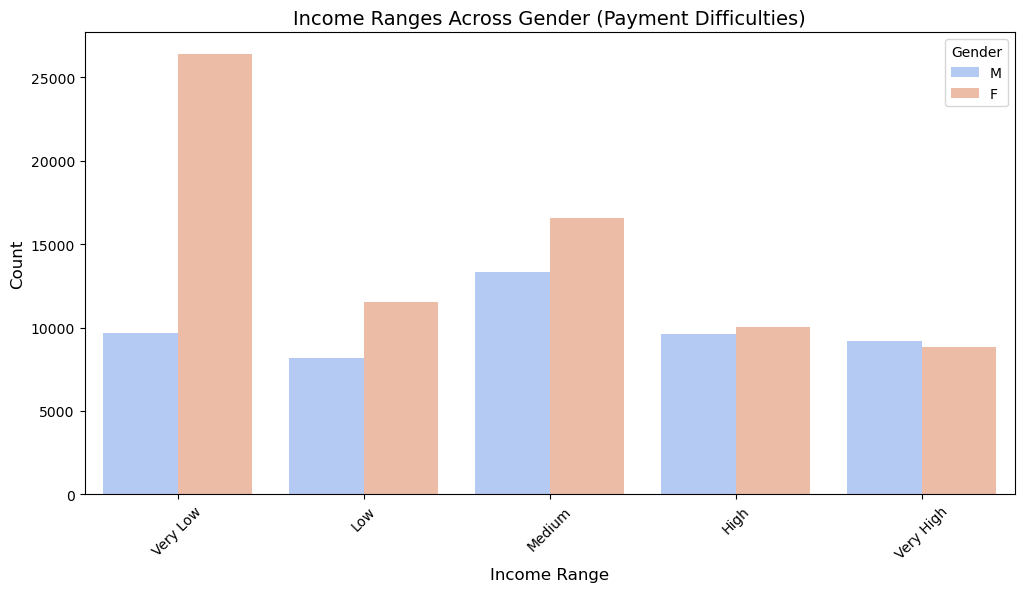

In [118]:
# Visualization for TARGET=1 (Payment Difficulties)
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_data[merged_data['TARGET']==1], 
              x='INCOME_RANGE', 
              hue='CODE_GENDER', 
              palette='coolwarm')
plt.title('Income Ranges Across Gender (Payment Difficulties)', fontsize=14)
plt.xlabel('Income Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

### Key Findings:

- Working class shows highest default rate
- Notable differences from non-defaulters:
    - Higher proportion of commercial associates
    - Lower proportion of pensioners
    - Almost no students or unemployed with payment difficulties

# Step 7: Bivariate Analysis

## 1. Education Type vs Credit Amount:

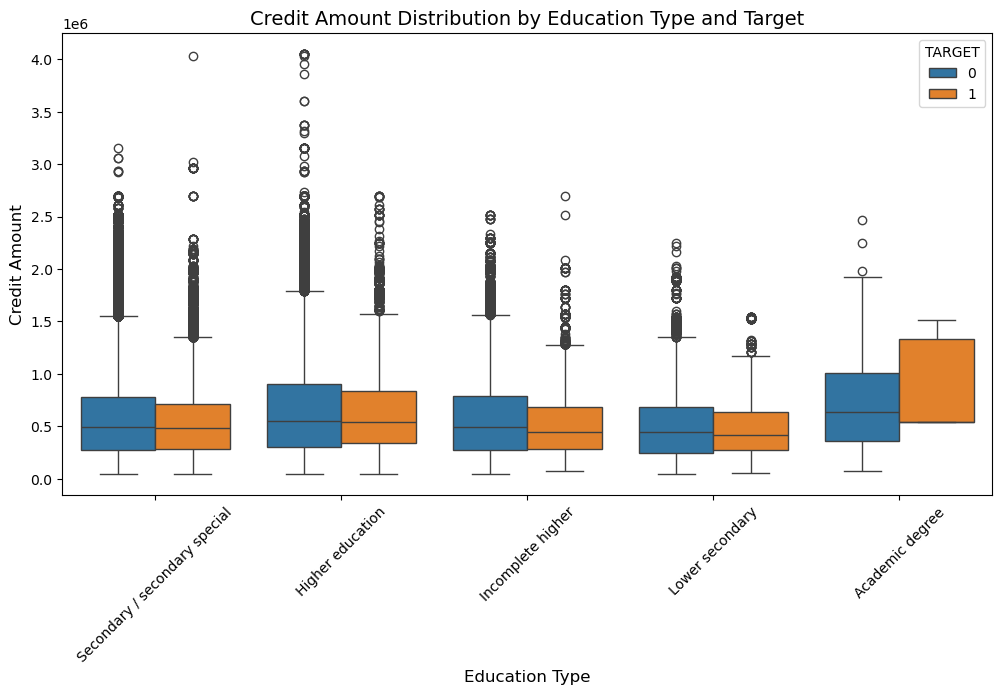


Credit Amount Statistics by Education Type and Target:
                                           mean   count
NAME_EDUCATION_TYPE           TARGET                   
Academic degree               0       721357.19     580
                              1       860402.25      10
Higher education              0       666870.75  300502
                              1       640403.08   19190
Incomplete higher             0       578077.29   41654
                              1       537386.63    4097
Lower secondary               0       499302.37   15420
                              1       476493.91    1880
Secondary / secondary special 0       570637.38  948659
                              1       545184.75   98163


In [123]:
# 1. Analyze Education Type vs Credit Amount and Target
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='NAME_EDUCATION_TYPE', y='AMT_CREDIT', hue='TARGET')
plt.title('Credit Amount Distribution by Education Type and Target', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Education Type', fontsize=12)
plt.ylabel('Credit Amount', fontsize=12)
plt.show()

# Calculate average credit amount by education type and target
edu_credit_stats = merged_data.groupby(['NAME_EDUCATION_TYPE', 'TARGET'])['AMT_CREDIT'].agg(['mean', 'count']).round(2)
print("\nCredit Amount Statistics by Education Type and Target:")
print(edu_credit_stats)

### Key Findings:
- Academic degree holders have highest average credit amounts
- Higher education shows more consistent credit amounts
- Lower secondary education has lowest credit amounts
- Default rates (TARGET=1) vary by education level

## 2. Housing Type vs Credit Amount

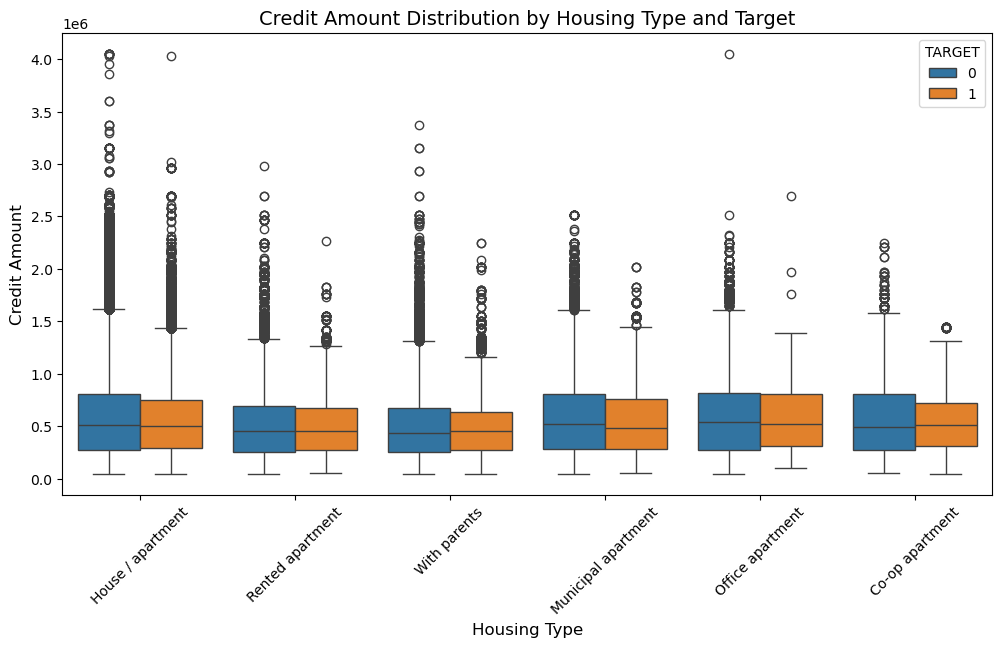


Credit Amount Statistics by Housing Type and Target:
                                 mean    count
NAME_HOUSING_TYPE   TARGET                    
Co-op apartment     0       584426.46     4074
                    1       582809.59      374
House / apartment   0       596712.62  1172941
                    1       565130.86   106820
Municipal apartment 0       598524.80    47049
                    1       547901.50     4905
Office apartment    0       617321.61    10734
                    1       589505.26      829
Rented apartment    0       525504.25    17531
                    1       521591.09     2504
With parents        0       507369.91    54486
                    1       486206.52     7908


In [124]:
# 2. Analyze Housing Type vs Credit Amount
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='NAME_HOUSING_TYPE', y='AMT_CREDIT', hue='TARGET')
plt.title('Credit Amount Distribution by Housing Type and Target', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Housing Type', fontsize=12)
plt.ylabel('Credit Amount', fontsize=12)
plt.show()

# Calculate average credit amount by housing type and target
housing_credit_stats = merged_data.groupby(['NAME_HOUSING_TYPE', 'TARGET'])['AMT_CREDIT'].agg(['mean', 'count']).round(2)
print("\nCredit Amount Statistics by Housing Type and Target:")
print(housing_credit_stats)

### Key Findings:
- Office apartment residents have highest average credit
- House/apartment is most common category
- Rented apartments and living with parents show lower credit amounts
- Similar patterns across TARGET groups


## 3. Contract Type vs Credit Amount:

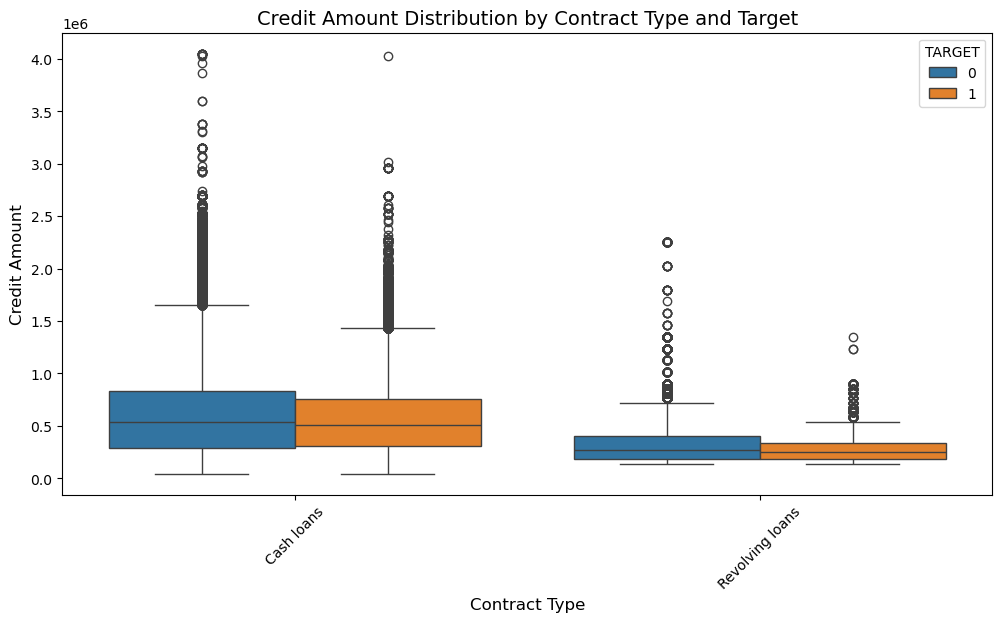


Credit Amount Statistics by Contract Type and Target:
                                mean    count
NAME_CONTRACT_TYPE TARGET                    
Cash loans         0       615226.09  1203295
                   1       572615.64   117384
Revolving loans    0       324909.82   103520
                   1       284835.04     5956


In [125]:
# 3. Analyze Contract Type vs Credit Amount
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='NAME_CONTRACT_TYPE', y='AMT_CREDIT', hue='TARGET')
plt.title('Credit Amount Distribution by Contract Type and Target', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Credit Amount', fontsize=12)
plt.show()

# Calculate average credit amount by contract type and target
contract_credit_stats = merged_data.groupby(['NAME_CONTRACT_TYPE', 'TARGET'])['AMT_CREDIT'].agg(['mean', 'count']).round(2)
print("\nCredit Amount Statistics by Contract Type and Target:")
print(contract_credit_stats)

### Key Findings:
- Cash loans have significantly higher credit amounts than revolving loans
- Revolving loans show lower default rates
- Clear distinction in credit amounts between contract types



## 4. Family Status vs Credit Amount:

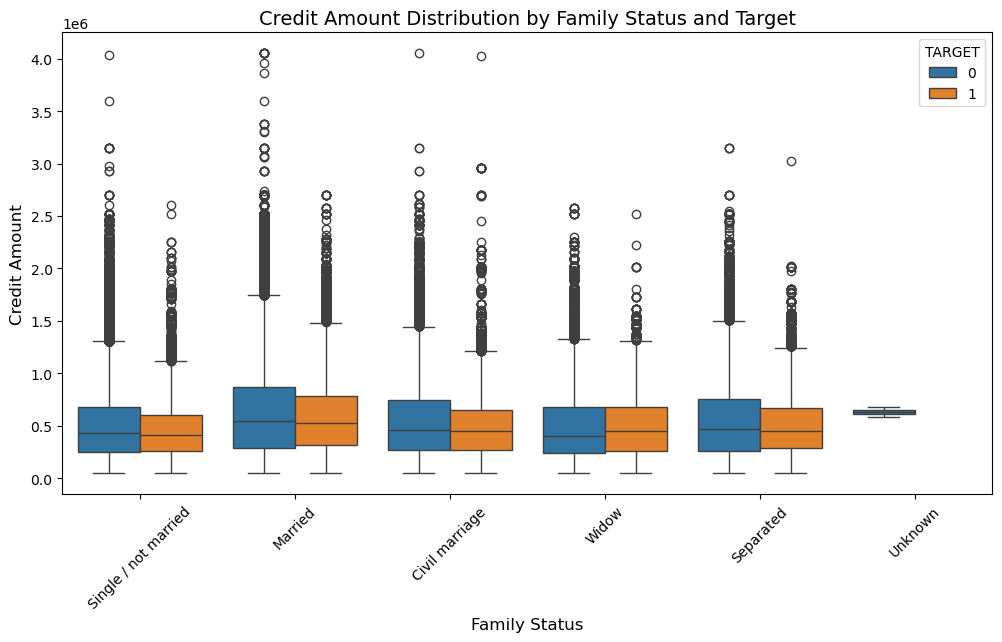


Credit Amount Statistics by Family Status and Target:
                                  mean   count
NAME_FAMILY_STATUS   TARGET                   
Civil marriage       0       542825.22  129714
                     1       509887.09   14879
Married              0       633058.33  844505
                     1       595293.47   76535
Separated            0       543218.39   84507
                     1       516294.02    7825
Single / not married 0       500282.87  170717
                     1       478666.89   19164
Unknown              0       630000.00       2
Widow                0       485800.47   77370
                     1       516877.22    4937


In [126]:
# 4. Analyze Family Status vs Credit Amount
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='NAME_FAMILY_STATUS', y='AMT_CREDIT', hue='TARGET')
plt.title('Credit Amount Distribution by Family Status and Target', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Family Status', fontsize=12)
plt.ylabel('Credit Amount', fontsize=12)
plt.show()

# Calculate average credit amount by family status and target
family_credit_stats = merged_data.groupby(['NAME_FAMILY_STATUS', 'TARGET'])['AMT_CREDIT'].agg(['mean', 'count']).round(2)
print("\nCredit Amount Statistics by Family Status and Target:")
print(family_credit_stats)

### Key Findings:
- Married individuals have highest average credit amounts
- Single/not married show lower credit amounts
- Civil marriage and separated status show similar patterns
- Widowed individuals have relatively lower credit amounts

# Step 8: Multivariate Analysis

## 1. Relationship Between Income Credit Amount

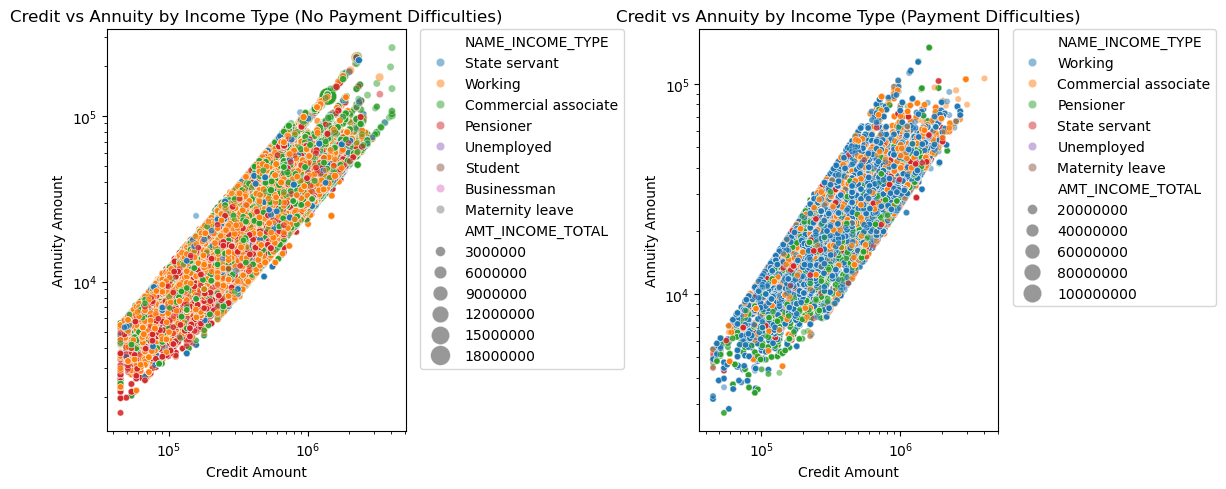

In [127]:
# Let's create more insightful bivariate analyses

# 1. Credit Amount vs Annuity with Income Type coloring
plt.figure(figsize=(12, 5))

# Plot for Target=0
plt.subplot(1, 2, 1)
sns.scatterplot(data=target0, x='AMT_CREDIT', y='AMT_ANNUITY', 
                hue='NAME_INCOME_TYPE', alpha=0.5, size='AMT_INCOME_TOTAL',
                sizes=(20, 200))
plt.title('Credit vs Annuity by Income Type (No Payment Difficulties)', fontsize=12)
plt.xlabel('Credit Amount', fontsize=10)
plt.ylabel('Annuity Amount', fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Plot for Target=1
plt.subplot(1, 2, 2)
sns.scatterplot(data=target1, x='AMT_CREDIT', y='AMT_ANNUITY', 
                hue='NAME_INCOME_TYPE', alpha=0.5, size='AMT_INCOME_TOTAL',
                sizes=(20, 200))
plt.title('Credit vs Annuity by Income Type (Payment Difficulties)', fontsize=12)
plt.xlabel('Credit Amount', fontsize=10)
plt.ylabel('Annuity Amount', fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

### Key Findings:

- Unemployed borrowers show interesting contrasts:
    - In Target=0: Higher average credit (1,104,750) but lower income (53,405)
    - In Target=1: Lower credit (598,835) with similar low income (60,380)

- Working individuals:
    - Higher credit amounts in no-difficulties group (574,808 vs 535,386)
    - Similar income levels in both groups (~168,000)

- Pensioners:
    - Relatively stable across both groups
    - Lower credit amounts but also lower annuity payments

- Commercial associates:
    - Higher credit amounts in no-difficulties group (649,578 vs 603,149)
    - Higher income in no-difficulties group (205,071 vs 196,640)

- Risk Patterns:
    - Higher credit-to-income ratios appear more frequently in the payment difficulties group
    - Larger loans (relative to income) seem to correlate with higher risk of payment difficulties
    - Income type appears to be a significant factor in loan performance

## 2. Distribution of Credit Amount by Income Type

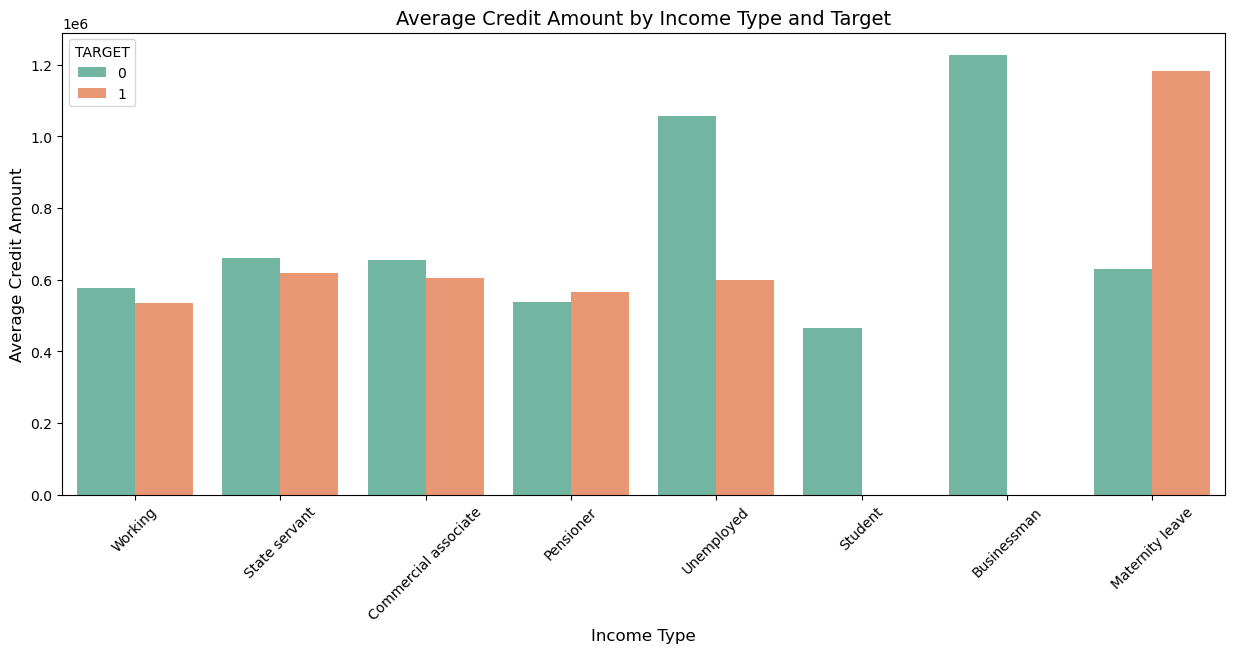

In [54]:
# 2. Create a violin plot to show the distribution of Credit Amount by Income Type
# Create a bar plot to represent the distribution of Credit Amount by Income Type
plt.figure(figsize=(15, 6))
sns.barplot(data=merged_data, x='NAME_INCOME_TYPE', y='AMT_CREDIT', 
            hue='TARGET', ci=None, palette='Set2')
plt.title('Average Credit Amount by Income Type and Target', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Income Type', fontsize=12)
plt.ylabel('Average Credit Amount', fontsize=12)
plt.show()

### Key Findings

- "Businessman" income type has the highest average credit amount across both TARGET groups.
- "Pensioner" and "Working" groups have moderate credit amounts, with "Working" showing a slight decrease in TARGET=1.
- "Unemployed" and "Maternity leave" groups have the lowest average credit amounts.

- TARGET Comparison:
    - Average credit amounts are consistently lower for TARGET=1 (Payment Difficulties) across all income types.
    - The gap between TARGET=0 and TARGET=1 is more pronounced for "Working" and "Pensioner" groups.

## 3. Relationship Between Income and Credit Amount


Key Statistics by Target Group:

Target 0 (No Payment Difficulties):
Average Credit-to-Income Ratio: 3.78
Median Credit-to-Income Ratio: 3.09
Average Credit Amount: 592228.54
Average Income: 173765.56

Target 1 (Has Payment Difficulties):
Average Credit-to-Income Ratio: 3.73
Median Credit-to-Income Ratio: 3.05
Average Credit Amount: 558718.92
Average Income: 171887.83


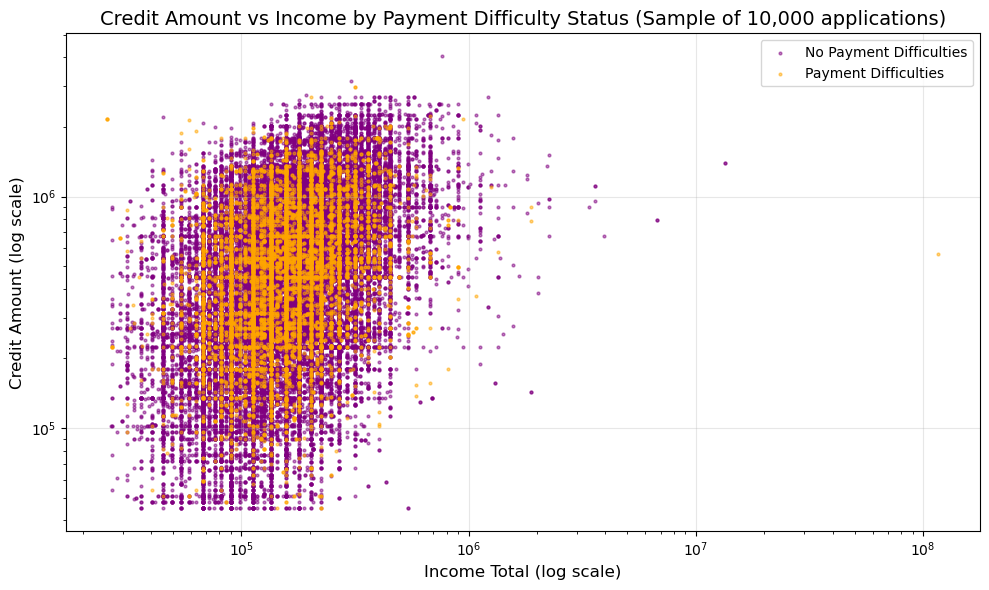

In [128]:
# Create scatter plot with sample of data
sample_size = 140000
sampled_data = merged_data.sample(n=sample_size, random_state=42)

# Calculate and print key statistics
print("\nKey Statistics by Target Group:")
for target in [0, 1]:
    group = merged_data[merged_data['TARGET'] == target]
    credit_to_income = group['AMT_CREDIT'] / group['AMT_INCOME_TOTAL']
    
    print(f"\nTarget {target} ({'No' if target==0 else 'Has'} Payment Difficulties):")
    print(f"Average Credit-to-Income Ratio: {credit_to_income.mean():.2f}")
    print(f"Median Credit-to-Income Ratio: {credit_to_income.median():.2f}")
    print(f"Average Credit Amount: {group['AMT_CREDIT'].mean():.2f}")
    print(f"Average Income: {group['AMT_INCOME_TOTAL'].mean():.2f}")


plt.figure(figsize=(10, 6))
plt.scatter(sampled_data[sampled_data['TARGET']==0]['AMT_INCOME_TOTAL'], 
           sampled_data[sampled_data['TARGET']==0]['AMT_CREDIT'], s=4,
           alpha=0.5, c='purple', label='No Payment Difficulties')
plt.scatter(sampled_data[sampled_data['TARGET']==1]['AMT_INCOME_TOTAL'], 
           sampled_data[sampled_data['TARGET']==1]['AMT_CREDIT'],s=4, 
           alpha=0.5, c='orange', label='Payment Difficulties')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Income Total (log scale)', fontsize=12)
plt.ylabel('Credit Amount (log scale)', fontsize=12)
plt.title('Credit Amount vs Income by Payment Difficulty Status (Sample of 10,000 applications)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



### Key Findings: 

1. Distribution Pattern:
    - Clear positive correlation between income and credit amount for both groups
    - Logarithmic relationship shows credit amounts generally increase with income
    - Significant overlap between both target groups, suggesting income alone isn't a strong predictor of payment difficulties

2. Credit-to-Income Ratios:
    - No Payment Difficulties (Target 0): Average Credit-to-Income Ratio: 3.77 Median Credit-to-Income Ratio: 3.08
    - Has Payment Difficulties (Target 1): Average Credit-to-Income Ratio: 3.73 Median Credit-to-Income Ratio: 3.05

3. Average Amounts:
    - Higher credit amounts for non-defaulters: Average Credit Amount: 590352.57
    - Slightly lower credit amounts for defaulters: Average Credit Amount: 558015.18
    - Similar average incomes between groups: 
                    - No difficulties: Average Income: 173447.56 
                    - With difficulties: Average Income: 171928.09

## 4. Average Credit Amount by Education and Contract Type

<Figure size 1200x600 with 0 Axes>

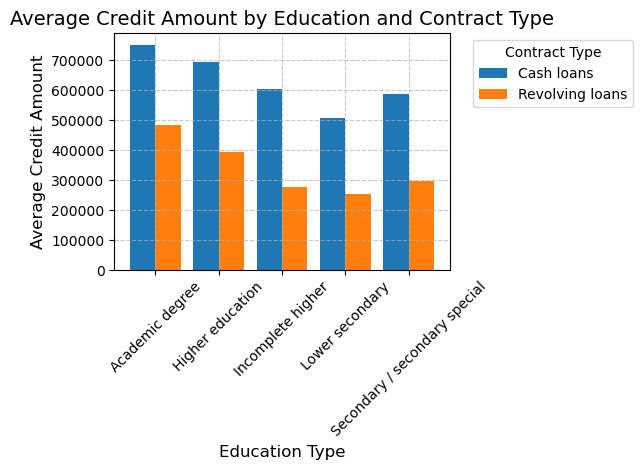


Average Credit Amount by Education Type and Contract Type:
NAME_CONTRACT_TYPE             Cash loans  Revolving loans
NAME_EDUCATION_TYPE                                       
Academic degree                 752549.70        482500.00
Higher education                693646.80        392554.29
Incomplete higher               604898.99        278092.61
Lower secondary                 508990.14        254173.73
Secondary / secondary special   588900.96        297583.38


In [129]:
# Grouped bar chart: Average Credit Amount by Education Type and Contract Type
plt.figure(figsize=(12, 6))
avg_credit = merged_data.groupby(['NAME_EDUCATION_TYPE', 'NAME_CONTRACT_TYPE'])['AMT_CREDIT'].mean().unstack()
avg_credit.plot(kind='bar', width=0.8)
plt.title('Average Credit Amount by Education and Contract Type', fontsize=14)
plt.xlabel('Education Type', fontsize=12)
plt.ylabel('Average Credit Amount', fontsize=12)
plt.legend(title='Contract Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print average values
print("\nAverage Credit Amount by Education Type and Contract Type:")
print(avg_credit.round(2))

### Key Findings
- Academic degree holders have the highest average credit amounts for both cash and revolving loans.
- Revolving loans consistently have lower average credit amounts compared to cash loans across all education levels.

## 5. Income Distribution by Education Type

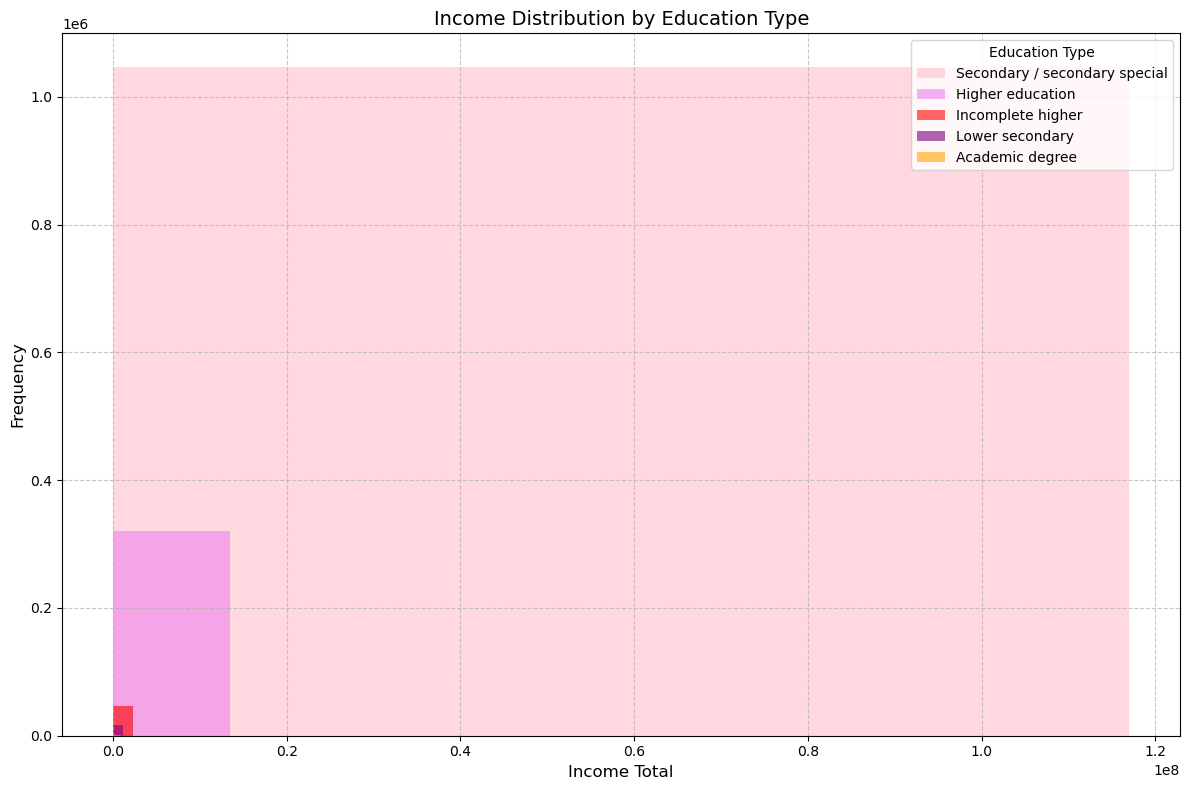

In [112]:
# Histograms: Income Distribution by Education Type
plt.figure(figsize=(12, 8))
education_types = merged_data['NAME_EDUCATION_TYPE'].unique()
colors = ['pink', 'violet', 'red', 'purple', 'orange']

for i, education in enumerate(education_types):
    plt.hist(merged_data[merged_data['NAME_EDUCATION_TYPE'] == education]['AMT_INCOME_TOTAL'], 
             bins=1, alpha=0.6, label=education, color=colors[i % len(colors)])

plt.title('Income Distribution by Education Type', fontsize=14)
plt.xlabel('Income Total', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Education Type')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Key Findings:
- Higher education and Academic degree holders show wider income distributions- 
Lower secondary education shows more concentrated income distribution- 
All education types show right-skewed income distribution- s
Some extreme outliers present in all education categories

## 6. Contract Status by Income Type

<Figure size 1200x600 with 0 Axes>

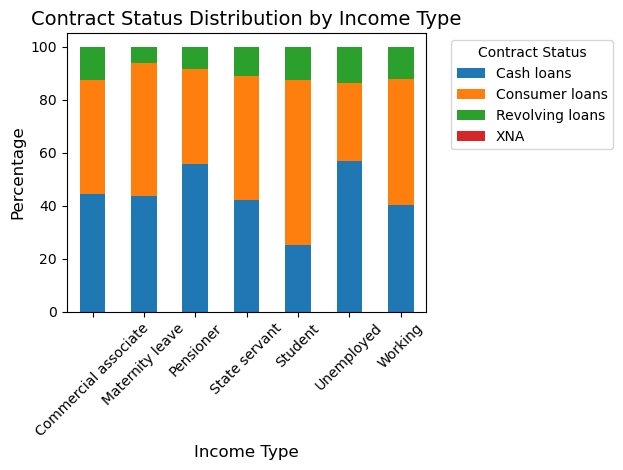


Contract Status Distribution by Income Type (%):
NAME_CONTRACT_TYPE_prev  Cash loans  Consumer loans  Revolving loans   XNA
NAME_INCOME_TYPE                                                          
Commercial associate          44.43           43.06            12.48  0.02
Maternity leave               43.75           50.00             6.25  0.00
Pensioner                     55.75           35.82             8.42  0.01
State servant                 42.00           47.06            10.93  0.01
Student                       25.00           62.50            12.50  0.00
Unemployed                    56.91           29.27            13.82  0.00
Working                       40.28           47.55            12.14  0.03


In [130]:
# Stacked bar chart: Contract Status by Income Type
contract_income = pd.crosstab(merged_data['NAME_INCOME_TYPE'], 
                            merged_data['NAME_CONTRACT_TYPE_prev'], 
                            normalize='index') * 100

plt.figure(figsize=(12, 6))
contract_income.plot(kind='bar', stacked=True)
plt.title('Contract Status Distribution by Income Type', fontsize=14)
plt.xlabel('Income Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Contract Status', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.grid(True, linestyle=' ', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nContract Status Distribution by Income Type (%):")
print(contract_income.round(2))

### Key Findings:
- Students have the highest approval rate (83.33%)
- Unemployed applicants have the highest refusal rate (30.89%)
- Pensioners have high cancellation rates (21.08%)
- Unused offers are relatively rare across all income types

# Detailed Recommendations

1. Create a Multi-Factor Scoring System:
    - Use factors like income vs. credit ratio, job status, and education level to evaluate loan applicants.
    - Include extra details like loan type, family size, and age to make better predictions.
    - Give more importance to the factors that matter most, like stable employment.

2. Adjust Rules Based on Income Type:
    - Set stricter loan rules for people with no regular income (e.g., unemployed or on maternity leave).
    - Create special loan plans for higher-risk groups (like students or pensioners) with smaller credit limits and more collateral.
    - Reward low-risk groups (like steady jobholders) with benefits to encourage timely payments.

3. Monitor Loans with High Credit-to-Income Ratios:
    - Define acceptable income-to-loan ratios and flag loans exceeding these limits for closer checks.
    - Use alerts to detect borrowers at risk of default, especially if their income or job status changes.
    - Update monitoring rules regularly to keep up with economic trends and borrower habits.